In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprocessing as mp
from matplotlib.patches import Wedge, Circle

%matplotlib inline
import numpy as np
import pandas as pd 
from sklearn import datasets, metrics
import time as time
from sklearn import svm
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
import seaborn
import cProfile
from io import StringIO
import pstats
import psutil
import threading
cores = psutil.cpu_count()
from sklearn import metrics
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import pkg_resources
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

from cirq.contrib.svg import SVGCircuit
from skimage.transform import resize

In [2]:
from keras.datasets import mnist

# Funcion globlal lectura datos MNIST

# Carga de datos en variables globales a los modelos

In [132]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x = train_x.reshape(60000, 784)
test_x = test_x.reshape(10000, 784)

indices_train = np.where((train_y == 3) | (train_y == 6))
x_train_filtered = train_x[indices_train]
y_train_filtered = train_y[indices_train]

# Filtrar las imágenes de 3 y 6 del conjunto de prueba
indices_test = np.where((test_y == 3) | (test_y == 6))
x_test_filtered = test_x[indices_test]
y_test_filtered = test_y[indices_test]


train_y = y_train_filtered
test_y = y_test_filtered

train_x = np.array([resize(image, (4, 4)) for image in x_train_filtered])
test_x = np.array([resize(image, (4, 4)) for image in x_test_filtered])

train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x /= 255
test_x /= 255

In [133]:
trainingSamples = len(train_x)
testingSamples = len(train_y)

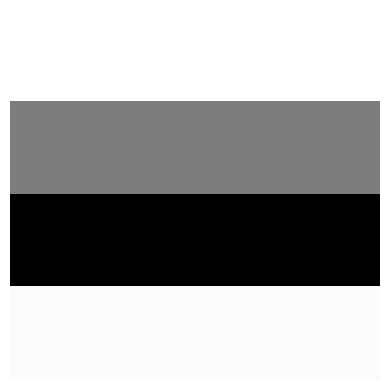

In [137]:
randDigitImage = train_x[543].reshape(4,4)
plt.imshow(randDigitImage, cmap=mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

# Modelo SVC

## 1. Variables locales

In [138]:
cpu_percent_list_train_svc = []
memory_usage_list_train_svc = []
cpu_percent_list_test_svc = []
memory_usage_list_test_svc = []

## 2. Funcion para buscar los mejores hiperparámetros

In [139]:
def busqueda_de_atributos_svc(modelo):
    scoring = 'accuracy'
    param_grid = {
    'kernel': ["linear", "poly", "rbf", "sigmoid"],
    'degree': [1,2,3,4,5],
    'shrinking': [True, False],
    'probability':[True, False],
    'class_weight': ["balanced", None],
    'decision_function_shape': ["ovo","ovr"]
    }
    
    grid_search = HalvingGridSearchCV(estimator=modelo, param_grid=param_grid, scoring=scoring, cv=3)
    grid_search.fit(train_x, train_y)

    return [grid_search.best_estimator_,grid_search.best_params_]

## 3. Funciones para monitorización de cpu y ram

In [140]:
def lists_cpu_and_ram_svc_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_svc.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_svc.append(currentProcess.memory_percent())
        
def start_svc_train():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_svc_train)
    t.start()

def stop_svc_train():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

In [141]:
def lists_cpu_and_ram_svc_test():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_test_svc.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_svc.append(currentProcess.memory_percent())
        
def start_svc_test():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_svc_test)
    t.start()

def stop_svc_test():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

## 4. Funcion para entrenar y testear el modelo

In [142]:
def entrenamientoyresultados_svc(modelo):
    
    clf_svc = modelo
    #Empezamos a contar el tiempo de entrenamiento
    startTrainingTime_svc = time.time()
    
    # Entrenamiento
    start_svc_train()
    try:
        clf_svc.fit(train_x, train_y)
    finally:
        stop_svc_train()


    #Terminamos de contar el tiempo de entrenamiento
    endTrainingTime_svc = time.time()

    #Calculamos el tiempo de entrenamiento
    trainingTime_svc = endTrainingTime_svc - startTrainingTime_svc  

    validResults_svc = 0

    #Empezamos a contar el tiempo de testeo
    
    startTestingTime_svc = time.time()
    start_svc_test()
    try:            
        predicted_svc = clf_svc.predict(test_x)
        precision_svc = metrics.accuracy_score(test_y, predicted_svc)
        
    finally:
        stop_svc_test()
    #Terminamos de contar el tiempo de testeo
    endTestingTime_svc = time.time()

    #Calculamos el tiempo de testeo
    testingTime_svc = endTestingTime_svc - startTestingTime_svc  # Calculation of testing time
    
    precision = round((validResults_svc / testingSamples) * 100, 2)
    
    return precision_svc*100,trainingTime_svc, testingTime_svc,clf_svc,predicted_svc


## 5. Resultados

In [143]:
#parametros = busqueda_de_atributos_svc(svm.SVC())

modelo_svc = svm.SVC(class_weight='balanced', decision_function_shape='ovo', degree=4,probability=True, shrinking=True)
resultados_svc = entrenamientoyresultados_svc(modelo_svc)

In [144]:
#print("Resultados con parametros: " + str(modelo[1]))
print("-------------------------------")
print("Muestras de entrenamiento: ", trainingSamples)
print("Tiempo de entrenamiento: ", round(resultados_svc[1], 2), " s")
print("Muestras de testeo: ", testingSamples)
print("Tiempo de testeo: ", round(resultados_svc[2], 2), " s")
print("Presición: ", resultados_svc[0], "%")
print("-------------------------------")
print("Uso de CPU en entrenamiento: ", cpu_percent_list_train_svc)
print("-------------------------------")
print("Uso de CPU en test: ", cpu_percent_list_test_svc)
print("-------------------------------")
print("Uso de RAM en entrenamiento: ", memory_usage_list_train_svc)
print("-------------------------------")
print("Uso de RAM en test: ", memory_usage_list_test_svc)

-------------------------------
Muestras de entrenamiento:  12049
Tiempo de entrenamiento:  3.01  s
Muestras de testeo:  12049
Tiempo de testeo:  1.0  s
Presición:  96.44308943089432 %
-------------------------------
Uso de CPU en entrenamiento:  [8.4, 8.241666666666667, 8.241666666666667]
-------------------------------
Uso de CPU en test:  [0.6666666666666666]
-------------------------------
Uso de RAM en entrenamiento:  [3.801961359216167, 3.8084467809498257, 3.801961359216167]
-------------------------------
Uso de RAM en test:  [3.801961359216167]


In [127]:
predicion_svc = resultados_svc[4]

## 6. Matriz de confusión

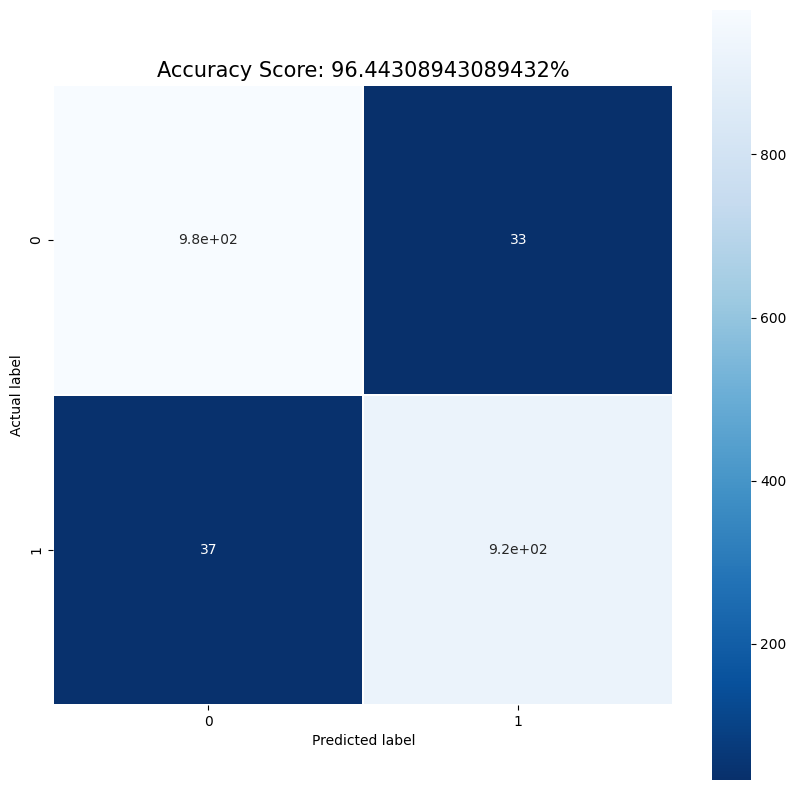

In [128]:
cm = metrics.confusion_matrix(test_y, predicion_svc)
plt.figure(figsize=(10,10))
seaborn.heatmap(cm, annot=True, linewidths=.25, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}%'.format(resultados_svc[0])
plt.title(all_sample_title, size = 15);


# Modelo MLP

## 1. Variables locales

In [73]:
cpu_percent_list_train_mlp = []
memory_usage_list_train_mlp= []
cpu_percent_list_test_mlp= []
memory_usage_list_test_mlp= []


## 2. Funcion para buscar los mejores hiperparámetros

In [74]:
def busqueda_de_atributos_mlp(modelo):
    scoring = 'accuracy'
    param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu','logistic','identity'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive','invscaling'],
    'max_iter':[5000,6000,7000]
}
    
    grid_search_mlp = HalvingGridSearchCV(estimator=modelo, param_grid=param_grid, scoring=scoring, cv=3)
    grid_search_mlp.fit(train_x, train_y)

    return [grid_search_mlp.best_estimator_,grid_search_mlp.best_params_]

## 3. Funciones para monitorización de cpu y ram

In [75]:
def lists_cpu_and_ram_mlp_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_mlp.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_mlp.append(currentProcess.memory_percent())
        
def start_mlp_train():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_mlp_train)
    t.start()

def stop_mlp_train():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

In [76]:
def lists_cpu_and_ram_mlp_test():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_mlp.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_mlp.append(currentProcess.memory_percent())
        
def start_mlp_test():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_mlp_test)
    t.start()

def stop_mlp_test():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

## 4. Funcion para entrenar y testear el modelo

In [97]:
def entrenamientoyresultados_mlp(modelo):
    
    clf_mlp = modelo
    #Empezamos a contar el tiempo de entrenamiento
    startTrainingTime_mlp = time.time()
    
    # Entrenamiento
    start_mlp_train()
    try:
        clf_mlp.fit(train_x, train_y)
    finally:
        stop_mlp_train()


    #Terminamos de contar el tiempo de entrenamiento
    endTrainingTime_mlp = time.time()

    #Calculamos el tiempo de entrenamiento
    trainingTime_mlp = endTrainingTime_mlp - startTrainingTime_mlp  

    validResults_mlp = 0

    #Empezamos a contar el tiempo de testeo
    
    startTestingTime_mlp = time.time()
    
    start_mlp_test()
    try:
        
        predicted_mlp = clf_mlp.predict(test_x)
        precision_mlp = metrics.accuracy_score(test_y, predicted_mlp)
        
    finally:
        stop_mlp_test()
    
    #Terminamos de contar el tiempo de testeo
    endTestingTime_mlp = time.time()

    #Calculamos el tiempo de testeo
    testingTime_mlp = endTestingTime_mlp - startTestingTime_mlp  # Calculation of testing time
    
    #precision_mlp = round((validResults_mlp / testingSamples) * 100, 2)
    
    return precision_mlp*100,trainingTime_mlp, testingTime_mlp,clf_mlp,predicted_mlp

## 5. Resultados

In [98]:
#parametros_mlp = busqueda_de_atributos_mlp(MLPClassifier())
modelo_mlp = MLPClassifier(alpha=0.05, max_iter=7000,activation = 'relu', hidden_layer_sizes= (100,100,), solver = 'adam', learning_rate = 'adaptive')
resultados_mlp = entrenamientoyresultados_mlp(modelo_mlp)

In [99]:
#print("Resultados con parametros: " + str(modelo[1]))
print("-------------------------------")
print("Muestras de entrenamiento: ", trainingSamples)
print("Tiempo de entrenamiento: ", round(resultados_mlp[1], 2), " s")
print("Muestras de testeo: ", testingSamples)
print("Tiempo de testeo: ", round(resultados_mlp[2], 2), " s")
print("Precisión: ", resultados_mlp[0], "%")
print("-------------------------------")
print("Uso de CPU en entrenamiento: ", cpu_percent_list_train_mlp)
print("-------------------------------")
print("Uso de CPU en test: ", cpu_percent_list_test_mlp)
print("-------------------------------")
print("Uso de RAM en entrenamiento: ", memory_usage_list_train_mlp)
print("-------------------------------")
print("Uso de RAM en test: ", memory_usage_list_test_mlp)

-------------------------------
Muestras de entrenamiento:  12049
Tiempo de entrenamiento:  10.02  s
Muestras de testeo:  12049
Tiempo de testeo:  1.0  s
Precisión:  51.32113821138211 %
-------------------------------
Uso de CPU en entrenamiento:  [90.06666666666666, 96.13333333333333, 97.3, 100.02499999999999, 99.89166666666667, 99.80833333333334, 99.90833333333335, 100.05833333333334, 99.97500000000001, 99.97500000000001, 11.891666666666666, 89.13333333333333, 97.97500000000001, 99.66666666666667, 97.97500000000001, 93.47500000000001, 96.85833333333333, 98.30833333333334, 93.80833333333334, 46.0, 92.20833333333333, 99.05833333333334, 96.64166666666667, 95.05833333333334, 99.94166666666666, 99.89166666666667, 99.89166666666667, 99.98333333333333, 99.80833333333334, 92.08333333333333, 91.21666666666665, 98.13333333333333, 95.30833333333334, 95.55, 99.19166666666666, 99.22500000000001, 96.14166666666667, 99.91666666666667, 92.03333333333335, 92.54166666666667, 95.41666666666667, 97.8, 9

In [100]:
predicion_mlp = resultados_mlp[4]

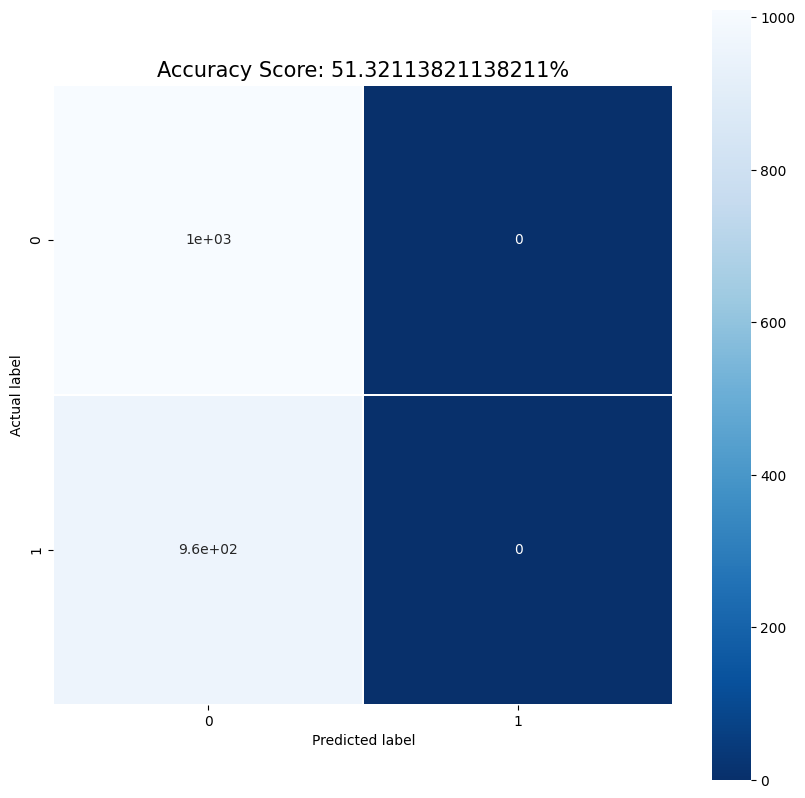

In [101]:
cm = metrics.confusion_matrix(test_y, predicion_mlp)
plt.figure(figsize=(10,10))
seaborn.heatmap(cm, annot=True, linewidths=.25, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}%'.format(resultados_mlp[0])
plt.title(all_sample_title, size = 15);

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
modelo = resultados_mlp[3]
ax.plot(modelo.loss_curve_)

plt.xlabel("number of steps") 
plt.ylabel("Loss")
plt.title("loss function")
plt.show()

# 3. TensorFlow Quantum

## 1. Inicialización de los datos

In [58]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

In [59]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [60]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

In [ ]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    
    
    return np.array(new_x), np.array(new_y)

In [61]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


## 2. Ejemplos de imagenes (una en 28x28 y otra en 4x4)

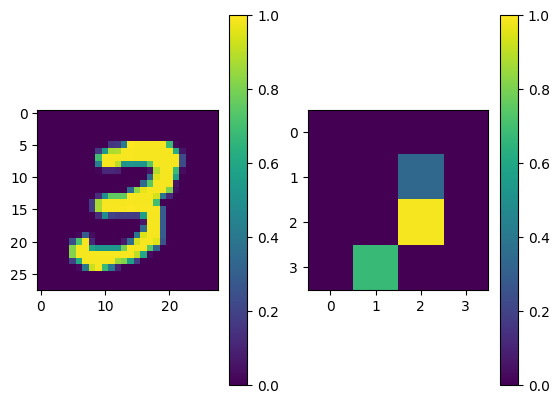

In [18]:
plt.subplot(1,2,1)
plt.imshow(x_train[0, :, :, 0]) #Imagen 0 con el canal de color 0,. cogiendo todas las filas y columnas
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

## 4. Binarización de los datos

In [27]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

## 5. Clases para la de creación del circuito cuántico

In [28]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
            #circuit.append(cirq.H(qubits[i])) #MIO POSIBLEMENTE QUITAR
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

In [29]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [30]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

## 6. Creación del modelo cuántico

In [31]:
def create_quantum_model():
    
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readouts = [cirq.GridQubit(-1, -1), cirq.GridQubit(-2,-2), cirq.GridQubit(-3,-3), cirq.GridQubit(-4,-4)]         
    circuit = cirq.Circuit()
    
    for readout in readouts:
        circuit.append(cirq.X(readout))
        circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [32]:
model_circuit, model_readout = create_quantum_model()

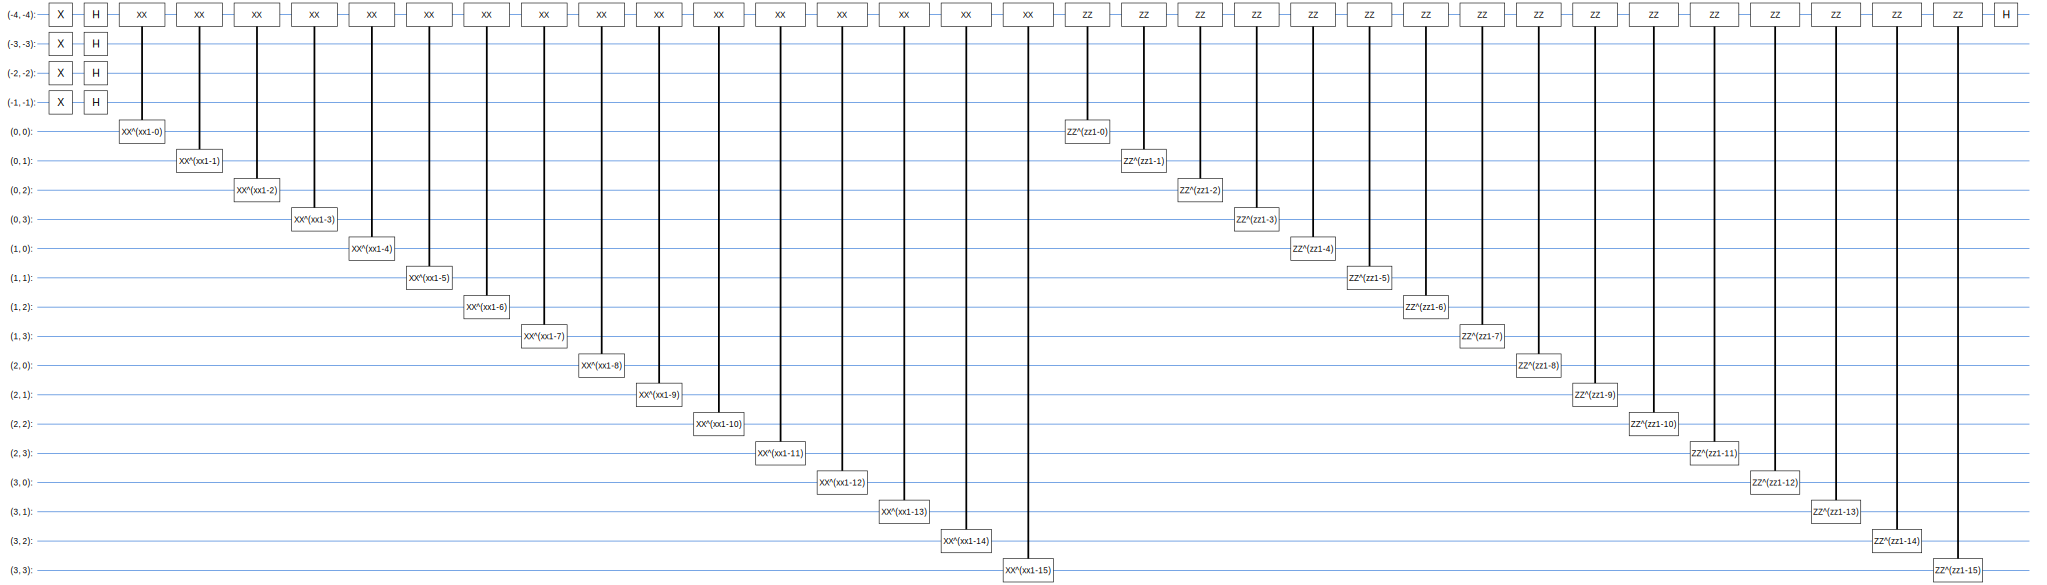

In [33]:
SVGCircuit(model_circuit)

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(model_circuit, model_readout),
])

In [35]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [36]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [37]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [38]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [40]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [ ]:
tfq_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

tfq_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
  2/324 [..............................] - ETA: 59:08 - loss: 0.9925 - hinge_accuracy: 0.6875  

In [31]:
qnn_accuracy = tfq_results[1]

## 7. Algunas gráficas

### 1. Precisión

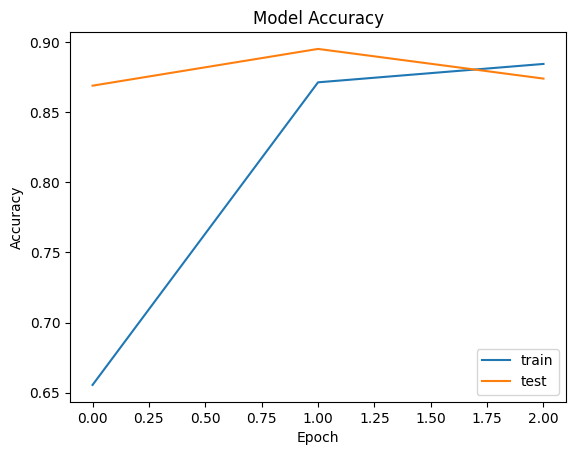

In [39]:
plt.plot(tfq_history.history['hinge_accuracy'])
plt.plot(tfq_history.history['val_hinge_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc="best")
plt.show()

### 2. Pérdidas

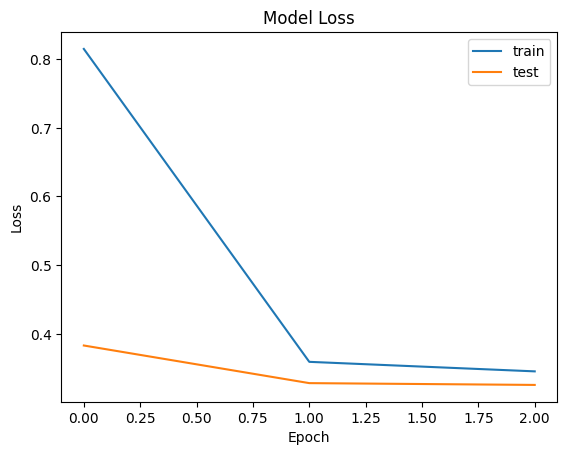

In [40]:
plt.plot(tfq_history.history['loss'])
plt.plot(tfq_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'],loc="best")
plt.show()

# 4. Comparaciones

In [24]:
list_classifiers = ['SVC', 'MLP']
val_scores = [resultados_svc[0], resultados_mlp[0]]

In [29]:
trace1 = go.Scatter(x = list_classifiers, y = val_scores,
                   name="Validation", text = list_classifiers)

data = [trace1]

layout = dict(title = "Validation and Submission Scores", 
              xaxis=dict(ticklen=10, zeroline= False),
              yaxis=dict(title = "Accuracy", side='left', ticklen=10,),                                  
              legend=dict(orientation="v", x=1.05, y=1.0),
              autosize=False, width=750, height=500,
              )

fig = dict(data = data, layout = layout)
iplot(fig)

<AxesSubplot: >

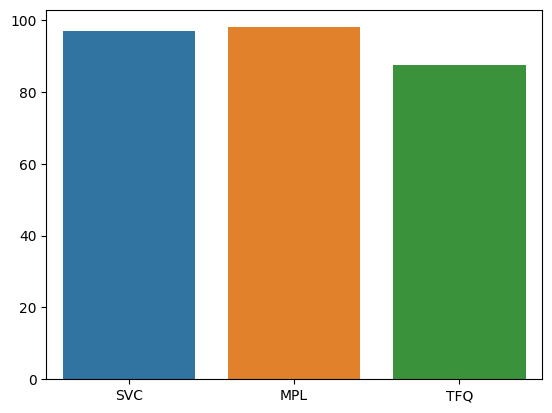

In [35]:
#seaborn.barplot(x=["SVC", "MPL","TFQ"],
            #y=[resultados_svc[0], resultados_mlp[0],qnn_accuracy])
    
seaborn.barplot(x=["SVC", "MPL","TFQ"],y=[97, 98, qnn_accuracy*100])

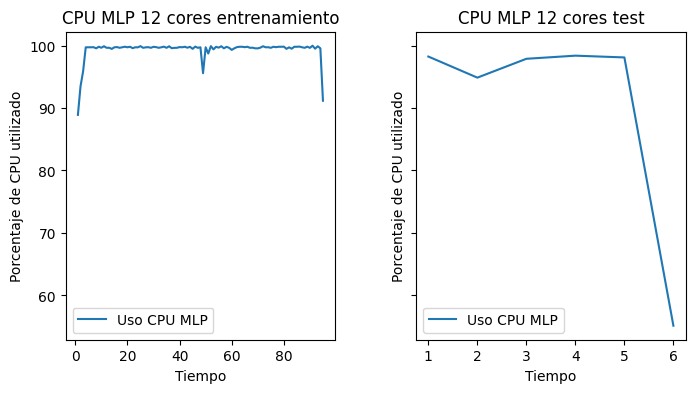

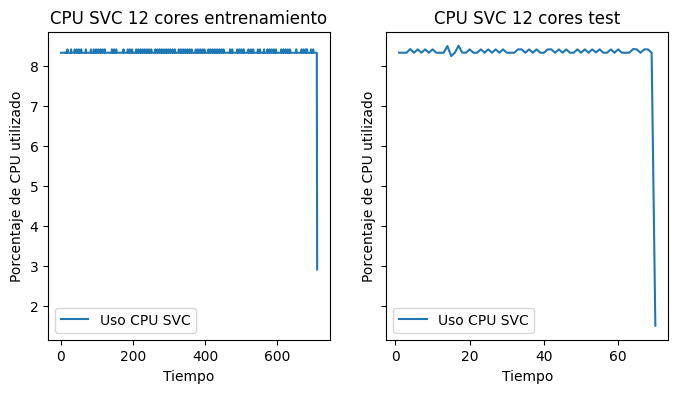

In [70]:
tiempo_entrenamieno_mlp = round(resultados_mlp[1], 2)
tiempo_entrenamiento_svc = round(resultados_svc[1],2)
tiempo_testeo_mlp = round(resultados_mlp[2],2)
tiempo_testeo_svc = round(resultados_svc[2],2)

tiempo_1 = np.arange(1,tiempo_entrenamieno_mlp)
datos_1 = cpu_percent_list_train_mlp

tiempo_2 = np.arange(1,tiempo_testeo_mlp)
datos_2 = cpu_percent_list_test_mlp

datos_3 = cpu_percent_list_train_svc
tiempo_3 = np.arange(1,tiempo_entrenamiento_svc)

datos_4 = cpu_percent_list_test_svc
tiempo_4 = np.arange(1,tiempo_testeo_svc)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
fig.subplots_adjust(wspace=0.3)
ax1.plot(tiempo_1, datos_1, label='Uso CPU MLP')
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Porcentaje de CPU utilizado')
ax1.set_title('CPU MLP 12 cores entrenamiento')
ax1.legend()

ax2.plot(tiempo_2, datos_2, label='Uso CPU MLP')
ax2.set_xlabel('Tiempo')
ax2.set_ylabel('Porcentaje de CPU utilizado')
ax2.set_title('CPU MLP 12 cores test')
ax2.legend()

# Creamos la figura y los ejes de la gráfica para el segundo tiempo
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
ax3.plot(tiempo_3, datos_3, label='Uso CPU SVC')
ax3.set_xlabel('Tiempo')
ax3.set_ylabel('Porcentaje de CPU utilizado')
ax3.set_title('CPU SVC 12 cores entrenamiento')
ax3.legend()

ax4.plot(tiempo_4, datos_4, label='Uso CPU SVC')
ax4.set_xlabel('Tiempo')
ax4.set_ylabel('Porcentaje de CPU utilizado')
ax4.set_title('CPU SVC 12 cores test')
ax4.legend()


# Mostramos ambas gráficas
plt.show()


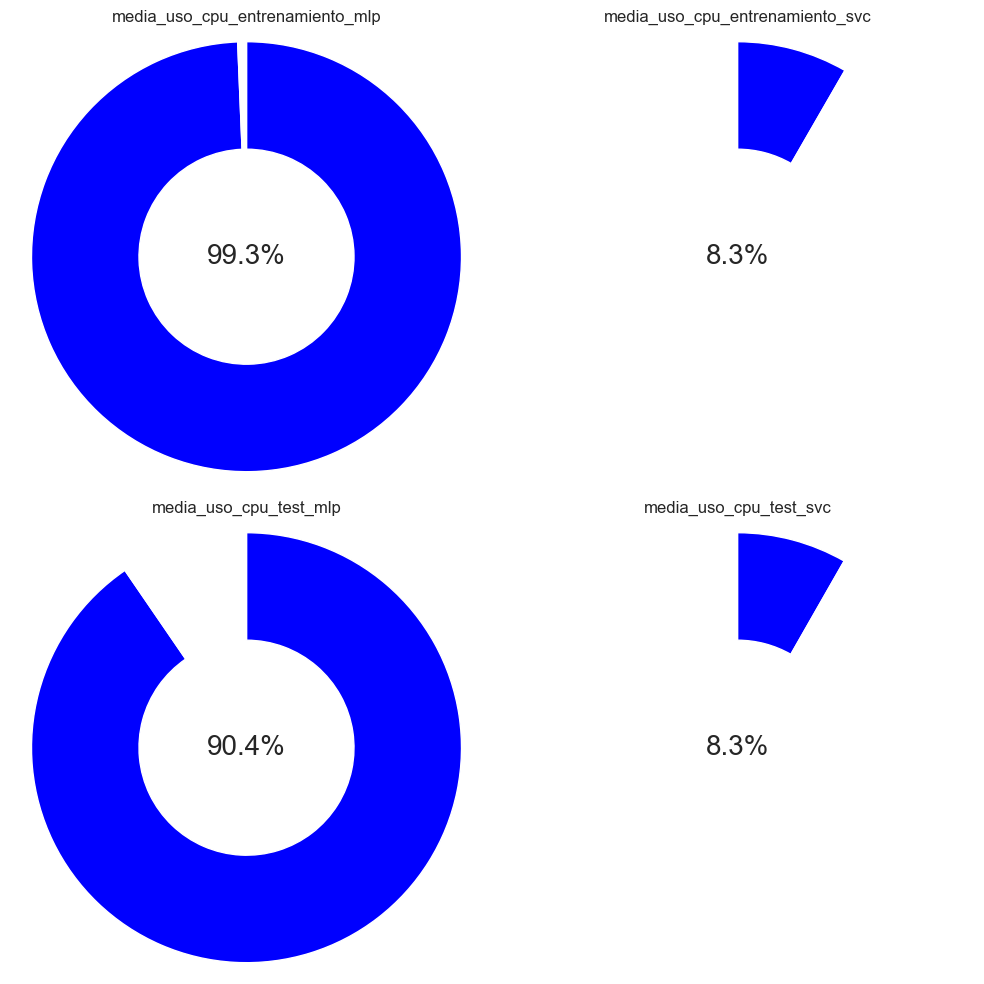

In [98]:
media_uso_cpu_entrenamiento_mlp = np.mean(cpu_percent_list_train_mlp)
media_uso_cpu_entrenamiento_svc = np.mean(cpu_percent_list_train_svc)
media_uso_cpu_test_mlp = np.mean(cpu_percent_list_test_mlp)
media_uso_cpu_test_svc = np.mean(cpu_percent_list_test_svc)
nombres = ['media_uso_cpu_entrenamiento_mlp','media_uso_cpu_entrenamiento_svc','media_uso_cpu_test_mlp','media_uso_cpu_test_svc']
# Creamos los datos para los gráficos
porcentajes = [media_uso_cpu_entrenamiento_mlp, media_uso_cpu_entrenamiento_svc, media_uso_cpu_test_mlp,media_uso_cpu_test_svc]

# Creamos los gráficos circulares con Seaborn
seaborn.set(style='whitegrid')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, porcentaje in enumerate(porcentajes):
    restante = 100 - porcentaje
    datos = [porcentaje, restante]
    row = i // 2
    col = i % 2
    
    axs[row, col].pie(datos, colors=['blue', 'white'], startangle=90, counterclock=False,
               wedgeprops={'width': 0.5, 'edgecolor': 'white'})
    
    axs[row, col].text(0, 0, f'{np.around((porcentaje),1)}%', ha='center', va='center', fontsize=20)
    axs[row, col].axis('equal')
    axs[row, col].set_title(nombres[i])

# Ajustamos la figura y mostramos los gráficos
fig.tight_layout()
plt.show()





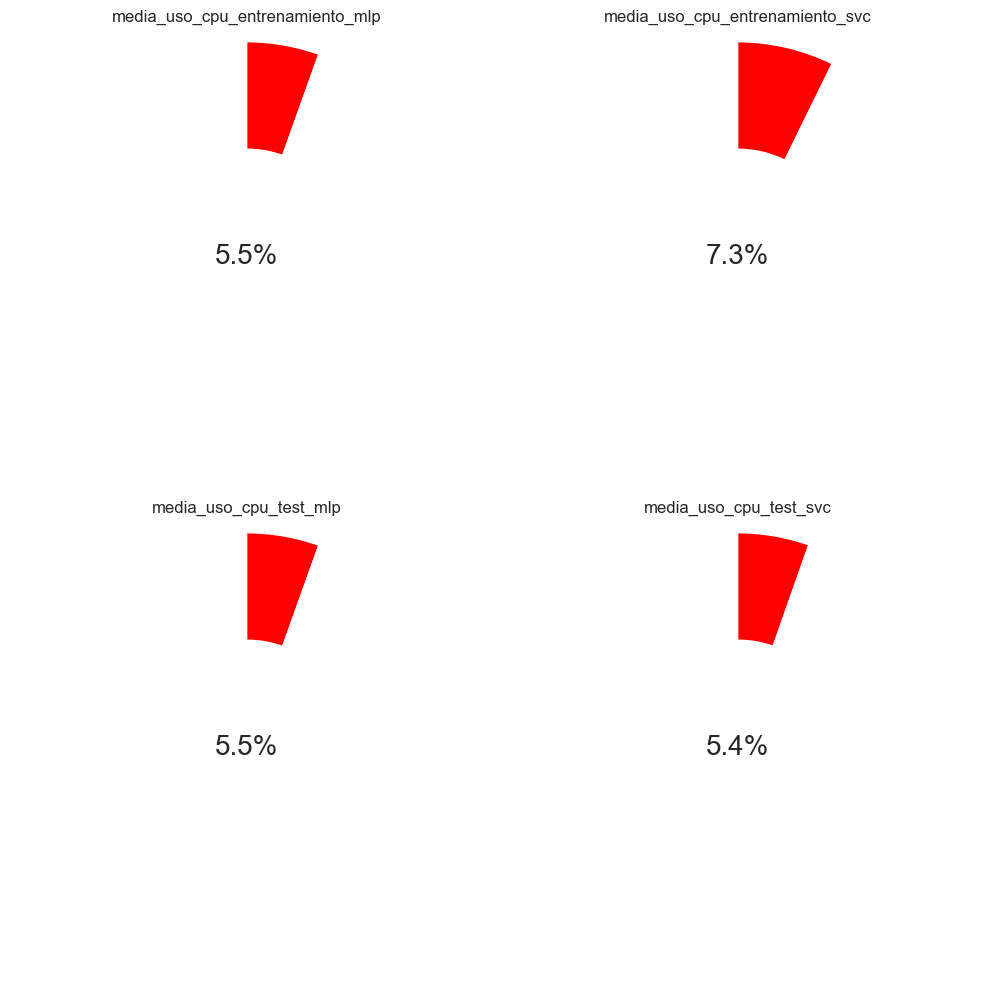

In [101]:
media_uso_ram_entrenamiento_mlp = np.mean(memory_usage_list_train_mlp)
media_uso_ram_entrenamiento_svc = np.mean(memory_usage_list_train_svc)
media_uso_ram_test_mlp = np.mean(memory_usage_list_test_mlp)
media_uso_ram_test_svc = np.mean(memory_usage_list_test_svc)
nombres = ['media_uso_cpu_entrenamiento_mlp','media_uso_cpu_entrenamiento_svc','media_uso_cpu_test_mlp','media_uso_cpu_test_svc']
# Creamos los datos para los gráficos
porcentajes = [media_uso_ram_entrenamiento_mlp, media_uso_ram_entrenamiento_svc, media_uso_ram_test_mlp,media_uso_ram_test_svc]

# Creamos los gráficos circulares con Seaborn
seaborn.set(style='whitegrid')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, porcentaje in enumerate(porcentajes):
    restante = 100 - porcentaje
    datos = [porcentaje, restante]
    row = i // 2
    col = i % 2
    
    axs[row, col].pie(datos, colors=['red', 'white'], startangle=90, counterclock=False,
               wedgeprops={'width': 0.5, 'edgecolor': 'white'})
    
    axs[row, col].text(0, 0, f'{np.around((porcentaje),1)}%', ha='center', va='center', fontsize=20)
    axs[row, col].axis('equal')
    axs[row, col].set_title(nombres[i])

# Ajustamos la figura y mostramos los gráficos
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Tiempo de entrenamiento')

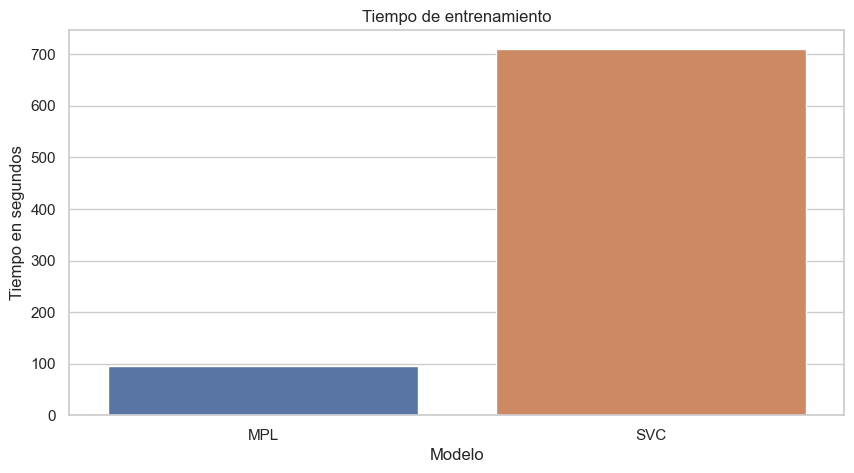

In [132]:
modelos = ["MPL", "SVC"]
counts = [tiempo_entrenamieno_mlp,tiempo_entrenamiento_svc]
fig = plt.figure(dpi=100, figsize=(10,5))
ax = fig.gca()
seaborn.barplot(x=modelos, y=counts, ax=ax, orient="v")
ax.set_ylabel("Tiempo en segundos")
ax.set_xlabel("Modelo")
ax.set_title(f"Tiempo de entrenamiento")

Text(0.5, 1.0, 'Tiempo de entrenamiento')

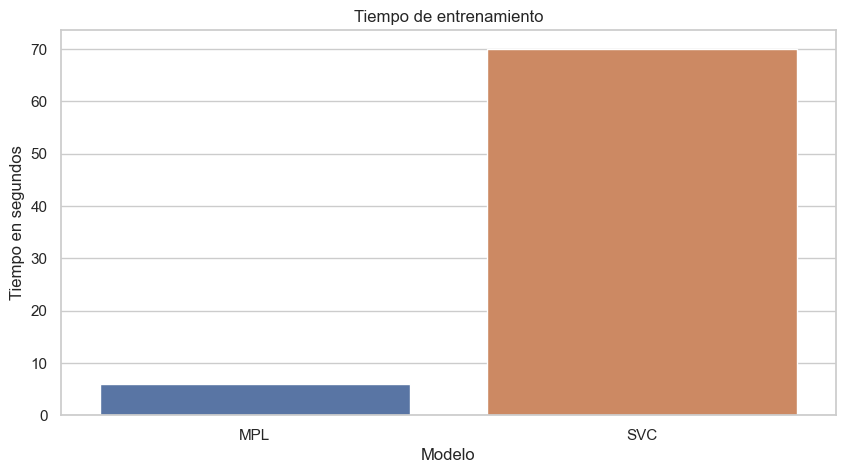

In [133]:
modelos = ["MPL", "SVC"]
counts = [tiempo_testeo_mlp,tiempo_testeo_svc]
fig = plt.figure(dpi=100, figsize=(10,5))
ax = fig.gca()
seaborn.barplot(x=modelos, y=counts, ax=ax, orient="v")
ax.set_ylabel("Tiempo en segundos")
ax.set_xlabel("Modelo")
ax.set_title(f"Tiempo de entrenamiento")